In [1]:
import numpy as np
import matplotlib
%matplotlib notebook
import matplotlib.pyplot as plt

from screening import *
from tools import *
import screening

In [2]:
# db folders
import os
DBdir = os.path.dirname(os.path.realpath(screening.__file__)) +"/DB"
bands_dir = os.path.dirname(os.path.realpath(screening.__file__)) +"/bands_GaSe"
DBdir

# units...
Atobohr = 1.8897259850078587

<IPython.core.display.Javascript object>


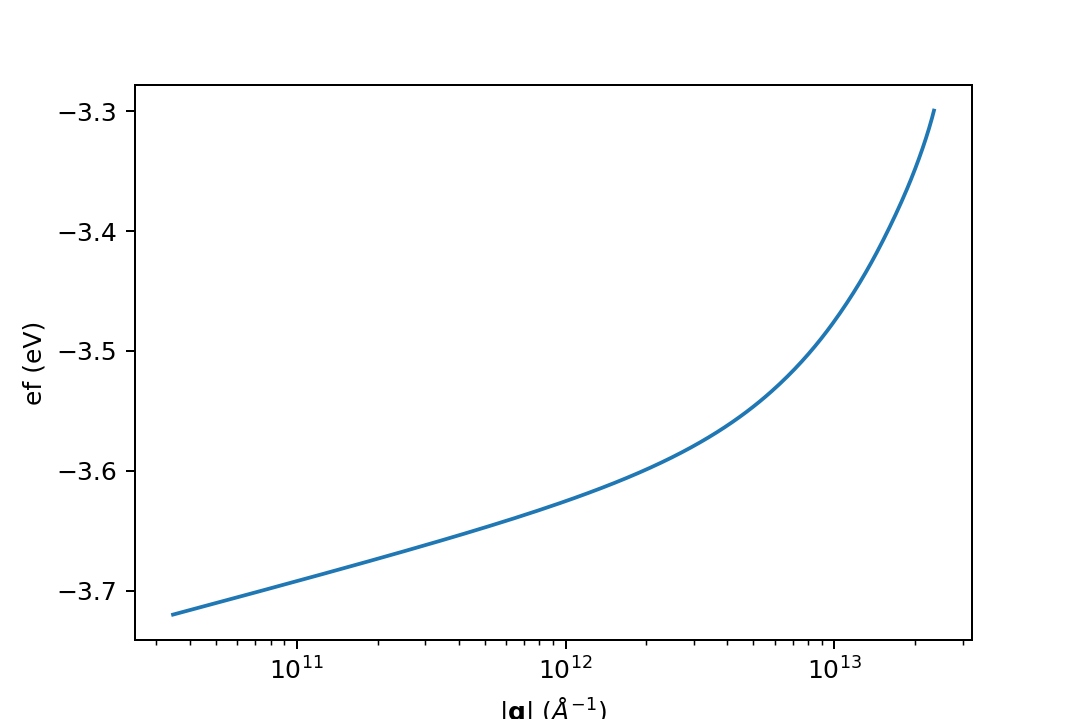

In [3]:
# preliminary analysis of the density vs Fermi level relationship in GaSe 
# compute a density <-> ef 
efs, ns = n_of_e(bands_dir,300*cte.KtoeV) # efs in eV, ns in electrons.cm-2

# plot it
fig, ax = plt.subplots(1,1,figsize = (6,4))

ax.semilogx(ns,efs)

ax.set_xlabel("n (cm-2)")
ax.set_ylabel("ef (eV)")
plt.show()

In [4]:
# from the above we deduce
ef1e13 = -3.475

# some input variables...
# note that input momenta are in A-1, input energies in eV.
qs = np.linspace(0.005,0.28, 50) # 50 qpoints, decrease for faster, test calculations.

transp = "GaSe"    # transport layer
space = "BN"       # separator, or "spacer"
screen = "Gr5e13"  # screener
#

In [5]:
# single layer  GaSe
layers = [transp]
dexps = []

#initialize
H = vdWH(layers, dexps)
H.set_qpoints(qs)

# add free carrier screening at 1e13
# comment out for neutral, change Fermi level ef for other doping
free_carrier(H, 'GaSe',bands_dir, ef1e13, kT = 0.026)

#solve (by default, for a monopole unit perturbation)
H.solve()

# induced potential Vind(q,z)
zs = H.get_zs(points_per_layer=51)
Vind = H.get_Vind(zs)

# dielectric function eps(q)
eps = H.get_eps()

qpoints set, parameters interpolated
computing monolayer response...
added free carrier response and put it back into VdWH
solving...
solved


<IPython.core.display.Javascript object>


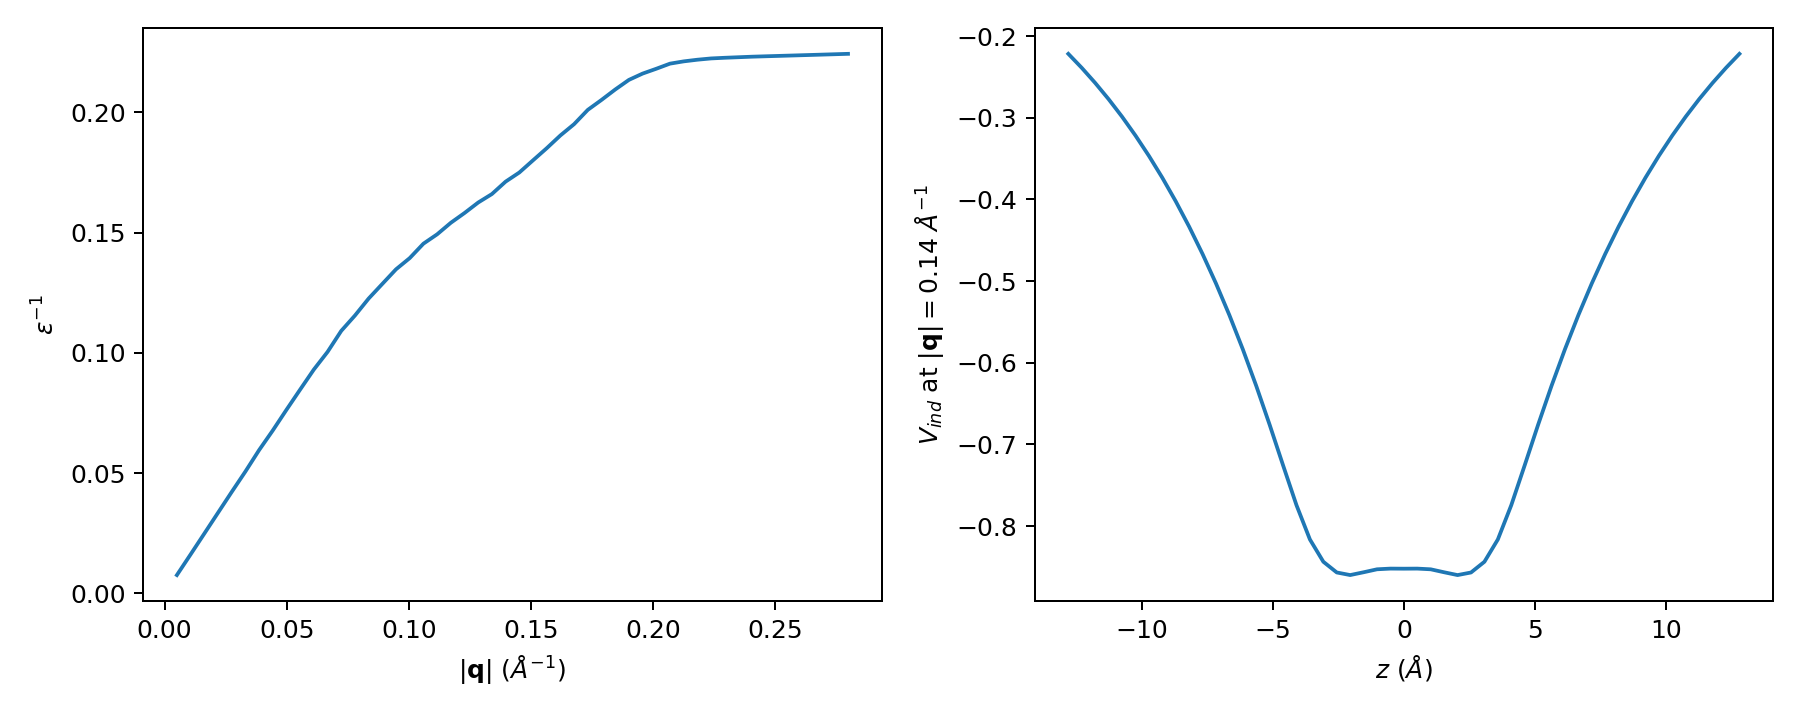

In [6]:
fig, axs = plt.subplots(1,2,figsize = (10,4))

iq = 25


axs[0].plot(qs, 1/eps)

axs[1].plot(zs/Atobohr,Vind[iq])

axs[0].set_ylabel(r'$\epsilon^{-1}$')
axs[0].set_xlabel(r'$|\mathbf{q}|$ ($\AA^{-1}$)')

axs[1].set_ylabel(r'$V_{ind}$ at $|\mathbf{q}| = $'+ str(qs[iq])[:4]+' $\AA^{-1}$')
axs[1].set_xlabel(r'$z$ ($\AA$)')

plt.tight_layout()
plt.show()

In [7]:
# GaSe, BN, Gr system
layers = [transp, space, screen]
dexps = [5.8*Atobohr, 3.4*Atobohr]

#initialize
H = vdWH(layers, dexps)
H.set_qpoints(qs)

# add free carrier screening at 1e13
# comment out for neutral, change Fermi level ef for other doping
free_carrier(H, 'GaSe',bands_dir, ef1e13, kT = 0.026)

# solve (by default, for a monopole unit perturbation)
H.solve()

# induced potential Vind(q,z)
zs = H.get_zs(points_per_layer=51)
Vind = H.get_Vind(zs)

# induced potential from GaSe, by specifying the index in ilayers
VindGaSe = H.get_Vind(zs, ilayers=[0])

# dielectric function
eps = H.get_eps()

# dielectric function from GaSe point of view
epsGaSe = H.get_eps(ilayers=[0])

qpoints set, parameters interpolated
computing monolayer response...
added free carrier response and put it back into VdWH
solving...
solved


<IPython.core.display.Javascript object>


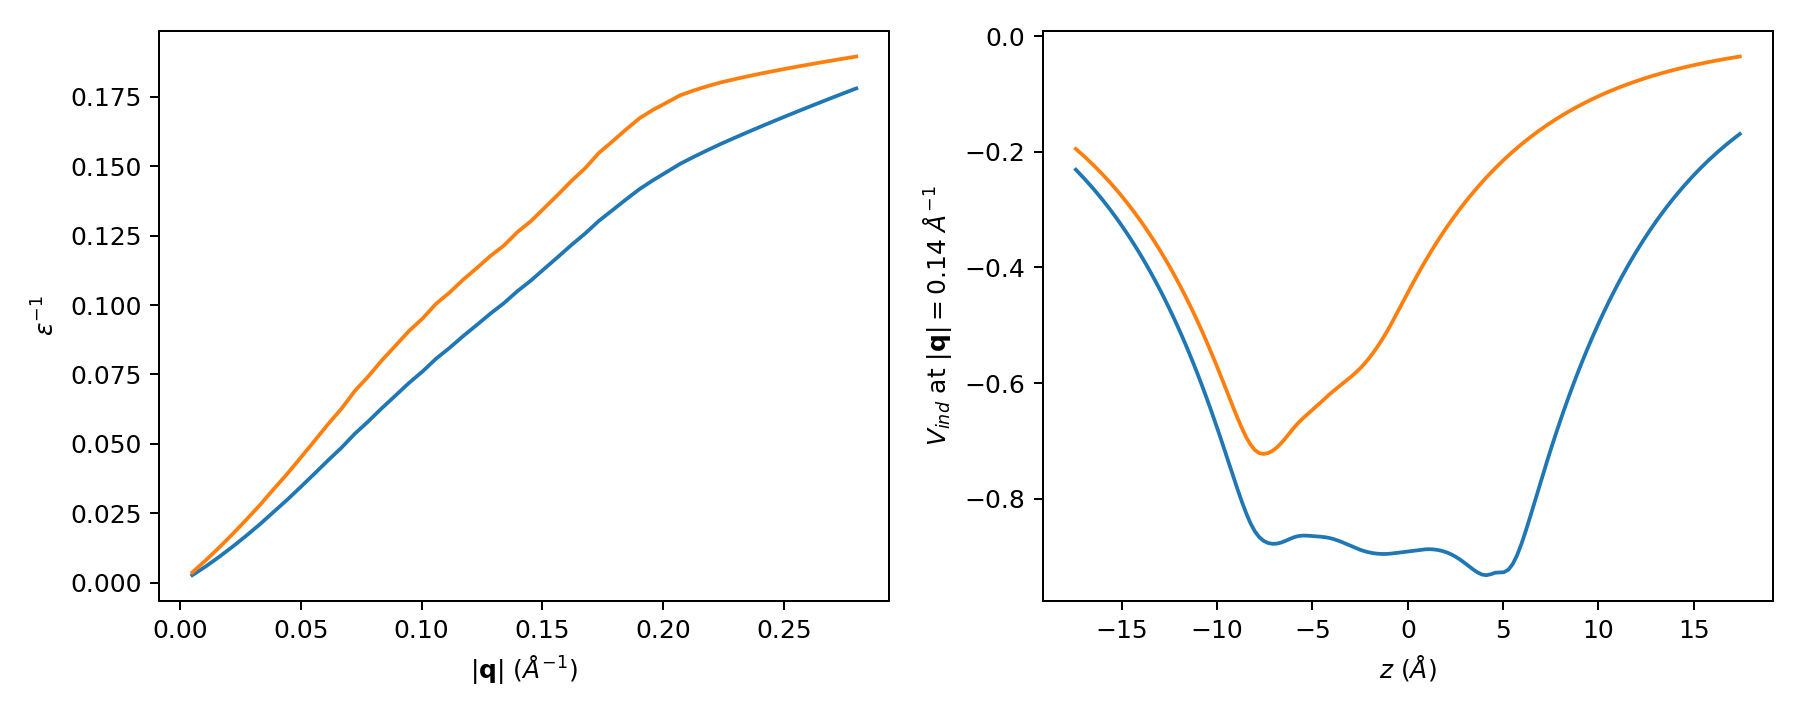

In [8]:
fig, axs = plt.subplots(1,2,figsize = (10,4))

iq = 25


axs[0].plot(qs, 1/eps)
axs[0].plot(qs, 1/epsGaSe)

axs[1].plot(zs/Atobohr,Vind[iq])
axs[1].plot(zs/Atobohr,VindGaSe[iq])

axs[0].set_ylabel(r'$\epsilon^{-1}$')
axs[0].set_xlabel(r'$|\mathbf{q}|$ ($\AA^{-1}$)')

axs[1].set_ylabel(r'$V_{ind}$ at $|\mathbf{q}| = $'+ str(qs[iq])[:4]+' $\AA^{-1}$')
axs[1].set_xlabel(r'$z$ ($\AA$)')

plt.tight_layout()
plt.show()

In [9]:
# Frohlich perturbation 

# GaSe, BN, Gr
layers = [transp, space, screen]
dexps = [5.8*Atobohr, 3.4*Atobohr]

#initialize
H = vdWH(layers, dexps)
H.set_qpoints(qs)

# add free carrier screening in GaSe at 1e13
# comment out for neutral, change Fermi level ef for other doping
free_carrier(H, 'GaSe',bands_dir, ef1e13, kT = 0.026)

# bare frohlich coupling amplitude (C_z)
Cs = {"BN": 1.994, "GaSe": 1.124, "Gr5e13":0.}
# material generating the Frohlich potential
mat = transp
# set up perturbation
Wfro = get_fro_pert(H,mat, qs, Cs) 

#solve
H.solve(W = Wfro)

# induced potential
zs = H.get_zs(points_per_layer=51)
Vind = H.get_Vind(zs)
# bare frohlich potential
Vfro = sum([Fro_pot(H, H.layers[il], zs, zl, Cs[H.layers[il]]) 
            for il, zl in enumerate(H.zlayers) if H.layers[il]==mat ])
# total potential
Vtot = Vfro+Vind

# Frohlich coupling, as felt by GaSe (potentials are in unit of coupling here)
gfro = H.potential_average(Vtot, zs, ilayers = [0])

qpoints set, parameters interpolated
computing monolayer response...
added free carrier response and put it back into VdWH
solving...
solved


<IPython.core.display.Javascript object>


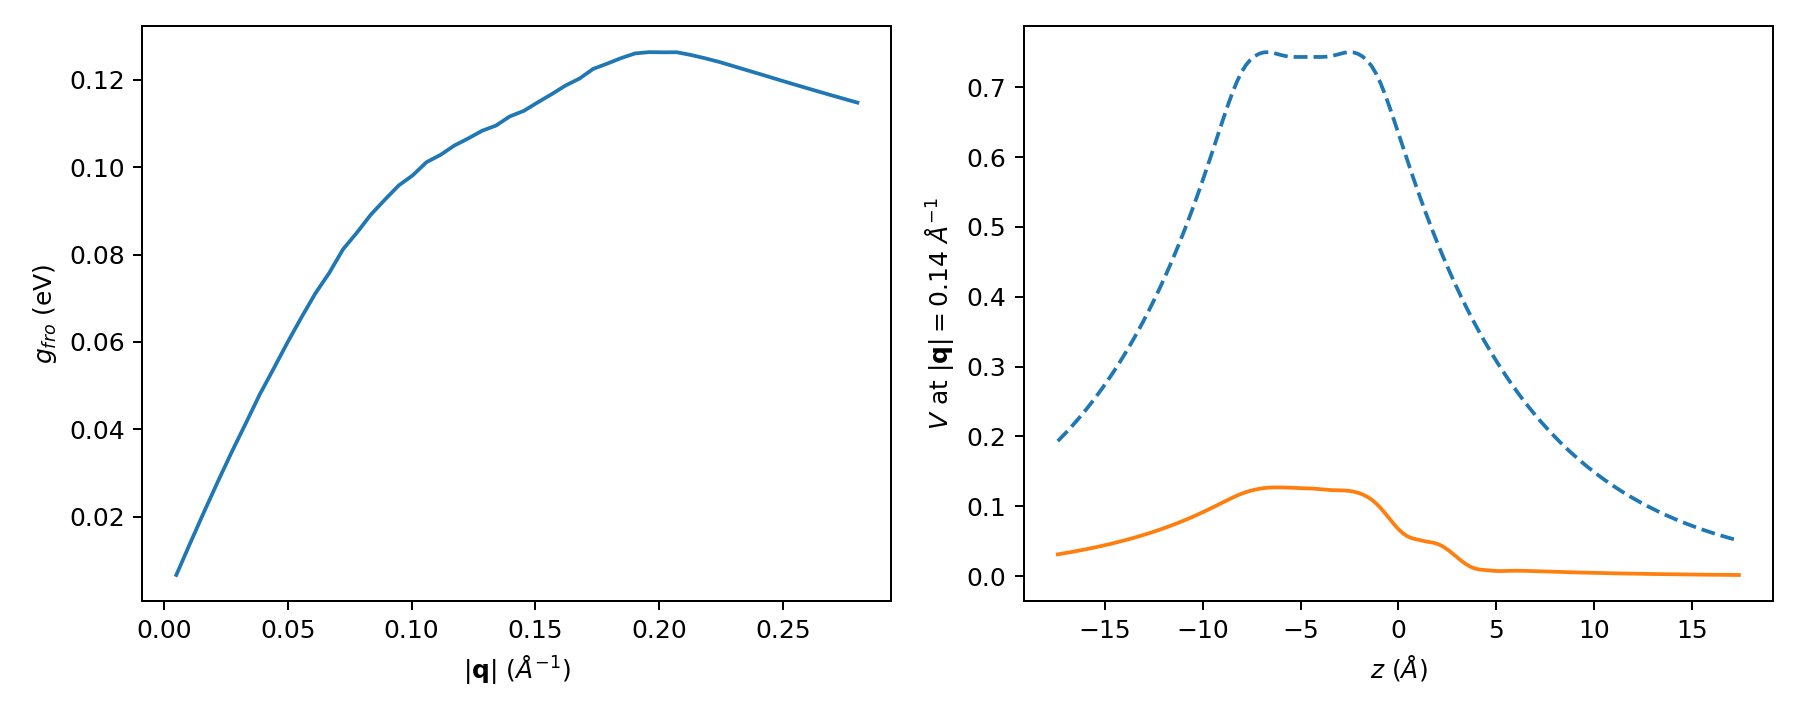

In [10]:
fig, axs = plt.subplots(1,2,figsize = (10,4))

iq = 25


axs[0].plot(qs, gfro)

axs[1].plot(zs/Atobohr,Vfro[iq], '--')
axs[1].plot(zs/Atobohr,Vtot[iq])

axs[0].set_ylabel(r'$g_{fro}$ (eV)')
axs[0].set_xlabel(r'$|\mathbf{q}|$ ($\AA^{-1}$)')

axs[1].set_ylabel(r'$V$ at $|\mathbf{q}| = $'+ str(qs[iq])[:4]+' $\AA^{-1}$')
axs[1].set_xlabel(r'$z$ ($\AA$)')

plt.tight_layout()
plt.show()




ax.set_xlabel(r'$|\mathbf{q}|$ ($\AA^{-1}$)')

plt.tight_layout()
plt.show()